# DC Bike Dangers


The Washington, DC mayor launch and has run on a campaign of ["Vision Zero"](https://visionzero.dc.gov/) in 2015 that wants to see 0 traffic related fatalities within the District but which has come under a large amount of criticism for its failures.  

Traffic related fatalities are at their [highest rate in decades in DC](https://www.washingtonpost.com/transportation/2022/10/27/dc-vision-zero-traffic-deaths/), but I want to focus on bike related accidents for the purposes of this analysis.  "Why?" You might ask yourself.  Well, because I love bikes and cycling, and it is my analysis, so bikes it is!

Thankfully, DC has a robust [Open Data Project](https://opendata.dc.gov/) that includes bicycle accident data.

### Data Index

[DC Bike Lane Data](https://opendata.dc.gov/datasets/bicycle-lanes/explore?location=38.894206%2C-77.013050%2C13.18)

This data breaks down every segment in DC that is considered a "bike lane" of any of the different type explained in the Types of Bike Lanes data set, below.  The only omission from this data are bike trails which are not contemplated in this analysis as they are completed separated from roads.

[DC Traffic Fatality Data](https://opendata.dc.gov/datasets/70392a096a8e431381f1f692aaa06afd_24/about)

This data set is all traffic related fatalities and started being captured in 2011.

[DC Parking Ticket Data](https://opendata.dc.gov/datasets/DCGIS::parking-violations-issued-in-july-2022/explore)

Bonus parking ticket data in case anyone is curious.

[DC Roadway Data](https://opendata.dc.gov/datasets/6fcba8618ae744949630da3ea12d90eb_163/explore?location=38.894287%2C-77.034017%2C16.11)

This is the data file the breaks down all of the different roadways and segments thereof in the District of Columbia.  There are also shape files that are used in maps in this notebook.

[Types of Bike Lanes in DC](https://ddotwiki.atlassian.net/wiki/spaces/GIS0225/pages/2053603403/Bikeway+Bikelane+Data)

This website is good context to understand the different types of bike lanes, as differentiated by the DC government.


### A Quick Note on a Shortcoming

Despite all of the great data that DC catalogues, there is no strong source for information about bike traffic.  The problem this presents in my analysis is that I cannot take bike accidents as compared to bike traffic on that same stretch of road.  There are bike traffic monitoring stations, but they are very limited.

For the scope of my analysis here, I will acknowledge this issue and drive (no pun intended) forward, but in a more in-depth context, I would try to find a way to normalize the accident data against the 4 monitoring stations.

In [1]:
# Not-exhaustive project checklist
# Note: this is not a writing assignment, but you should still incorporate comments or headers throughout
# -- This will help others who review your work, but will also help you keep track of what you're doing
# -- Just think about what would help you understand a peer's project when you have to grade theirs later


# 1) Dataset included
# 1a) Dataset explained/documented when used
# 2) Analysis performed
# 2a) Analysis steps documented, explained briefly
# 3) Visualizations/outputs
# 4) Conclusion
# ---Did you answer your questions?
# ---Did you find anything else?
# ---What problems did you run into?
# ---Any suggestions for future research?

# Critical checks before submission
# - Does the noteboook run without error? (Kernel>restart & run all => no errors at all? No long periods of processing?)
# - Do you have your dataset included here? You shouldn't be connecting to any external data
# - - Even if external datasets work here, they WILL NOT work for peer-grading, and you may get a 0.

In [2]:
# importing modules
import requests
import io
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Vision Zero for Bikes

This will take a few seconds...


<AxesSubplot:>

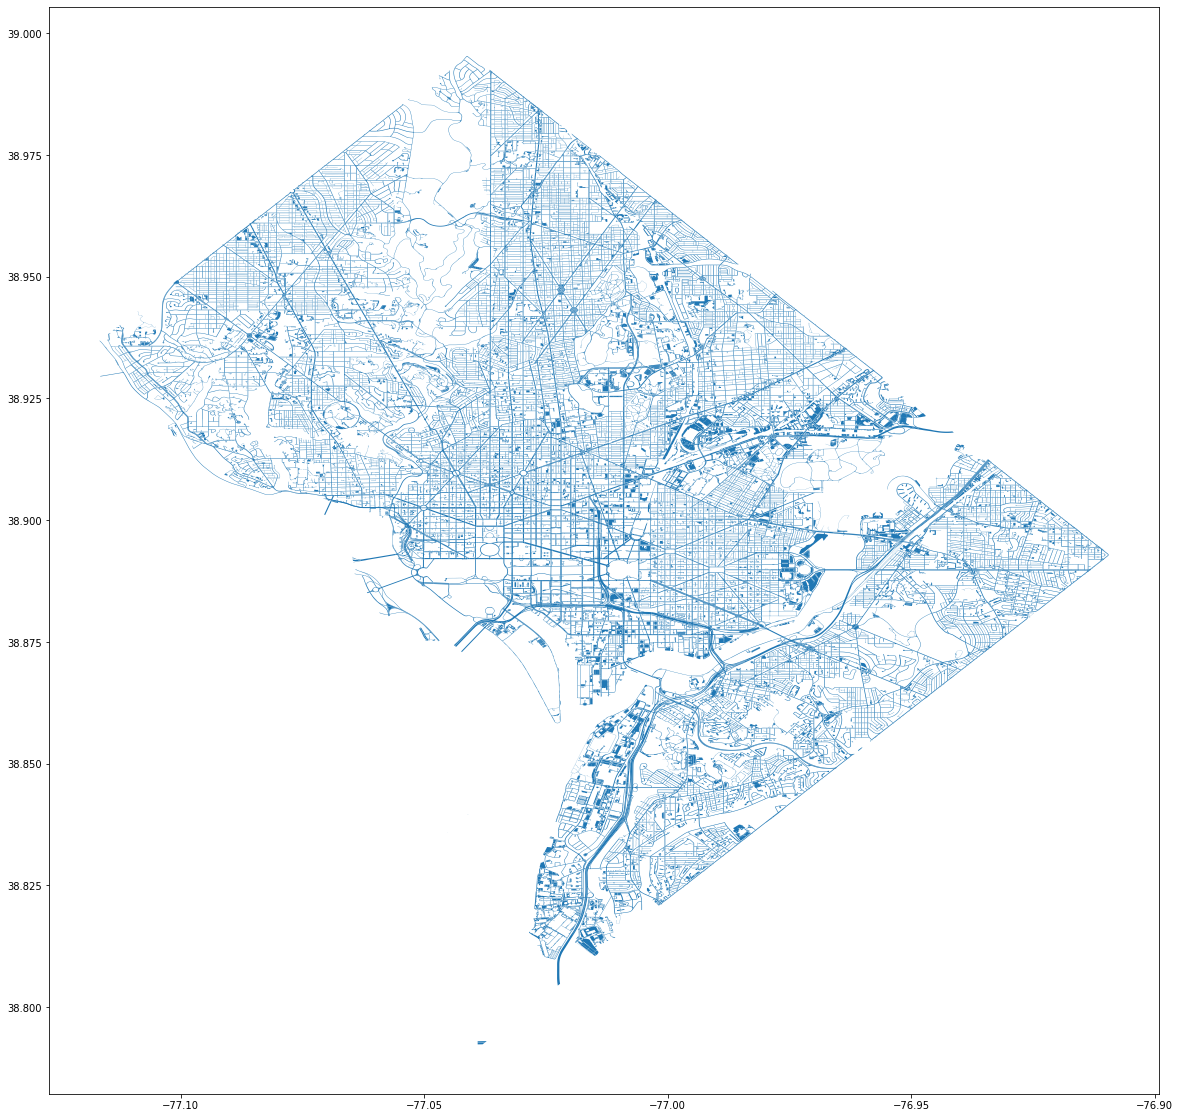

In [3]:
# create a data file of road polygons in DC
shp_path = "Roads.shp"
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')

# plot all of the roads
print('This will take a few seconds...')
roads.plot(figsize=(20,20))

As you can see, despite the District of Columbia being only 68.3 square miles in size, there are a lot of roads.  By extension, there are a lot of places to ride a bike. I want to take a quick look at some high-level bike numbers with Vision Zero as the backdrop.  I don't want this analysis to focus on the purported shortcomings of legislative action or lack thereof, but it is interesting context.

For anyone who is curious, the Elipse at X = -77.03 Y = 38.88 is just South of the White House and just North of the Washington Monument.  It is also, conveniently, in downtown DC which we will later see will be the focus of this analysis.


### Bike Crash Data

Here I import the data into crashes_df.  This is the data source from which I will conduct the majority of my analysis.  DC began cataloging pedestrian and bike accident data in 2011.  I kept only the data concerning bike accidents as that is the focus of this analysis, and becaues the full dataset was above the size limits imposed in the assignment rules.  There are some inconsistencies in the data such as certain accidents being marked on "unable to find route" which I will address later, but overall, the data looks clean. 

In [4]:
# read in the crash data
crashes_df = pd.read_csv('Crashes_in_DC_bikes.csv')

# removing the time from the date reported field
crashes_df['Report_Date_Short'] = pd.to_datetime(crashes_df['REPORTDATE']).dt.date
# separating out the year
crashes_df['Report_Date_Year'] = pd.to_datetime(crashes_df['REPORTDATE']).dt.year
crashes_df

,X,Y,OBJECTID,CRIMEID,CCN,REPORTDATE,ROUTEID,MEASURE,OFFSET,STREETSEGID,...,MPDLONGITUDE,MPDGEOX,MPDGEOY,FATALPASSENGER,MAJORINJURIESPASSENGER,MINORINJURIESPASSENGER,UNKNOWNINJURIESPASSENGER,MAR_ID,Report_Date_Short,Report_Date_Year
0,-77.029727,38.936287,143759011,23950462,12046793,2012/04/06 13:59:00+00,11001302,4411.76,0.59,1562.0,...,-77.029732,NaN,NaN,0,0,0,0,230353,2012-04-06,2012
1,-77.034595,38.901344,143759032,23962926,11164839,2011/11/09 05:00:00+00,11001502,1460.99,0.00,7180.0,...,-77.034593,NaN,NaN,0,0,0,0,279976,2011-11-09,2011
2,-77.029612,38.905655,143759187,23985330,12060521,2012/05/04 11:28:00+00,11057852,1740.48,1.26,12913.0,...,-77.029610,NaN,NaN,0,0,0,0,308115,2012-05-04,2012
3,-77.023981,38.907251,143759390,24004749,12014404,2012/01/30 00:00:00+00,11063182,1250.67,0.16,7719.0,...,-77.023979,NaN,NaN,0,0,0,0,239742,2012-01-30,2012
4,-77.037436,38.928948,143759521,24081921,12093773,2012/07/05 22:57:00+00,11062532,256.29,21.13,5852.0,...,-77.037666,NaN,NaN,0,0,0,0,236441,2012-07-05,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4805,-77.022301,38.902108,144032780,37971460584,22157533,2022/10/30 09:33:00+00,11050892,1148.21,35.41,NaN,...,-77.022299,NaN,NaN,0,0,0,0,319934,2022-10-30,2022
4806,-77.020991,38.899820,144032800,37906591095,22157052,2022/10/29 06:35:00+00,11042442,1127.05,23.53,NaN,...,-77.020988,NaN,NaN,0,0,0,0,238694,2022-10-29,2022
4807,-77.027039,38.918119,144032833,37807773044,22155494,2022/10/26 18:24:00+00,11001102,2594.80,0.03,NaN,...,-77.027036,NaN,NaN,0,0,0,0,283915,2022-10-26,2022
4808,-77.002035,38.917002,144032840,37811238290,22155637,2022/10/26 20:32:00+00,12000302,2484.47,0.01,NaN,...,-77.002033,NaN,NaN,0,0,0,0,53140,2022-10-26,2022


Of particular note in this data are the following:
- ROUTEID: This is the unique identifier for the roadway section on which the accident occurred.  This number can be used in all road related data sets from DC Open Data.
- FATALBICYCLIST (et. al): These tell you who was hurt in the crash.  I am going to specifically focus on bike related injuries and fatalities.  Therfore, if there is an instance where driver was hurt in a bike accident, it will not be counted.
- REPORTDATE: The date of the accident.
- Latitude and Longitude Data

As a warm up, I group the accident data by years to see how bike accidents have faired under the mayor's Vison Zero program.  The red line in the plot indicates 2015, the year that Vison Zero kicked off.

    Year  Accidents
0   2011         12
1   2012        138
2   2013        136
3   2014        313
4   2015        233
5   2016        749
6   2017        882
7   2018        726
8   2019        704
9   2020        394
10  2021        390
11  2022        133


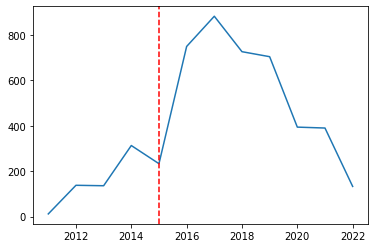

In [5]:
# organize the crash/fatality data by year and plot a line graph
crashes_by_year = crashes_df.groupby(by='Report_Date_Year', as_index=False).count()

# dropping unnecessary columns - I listed them out so that folks can see all of them
crashes_by_year.drop(['X', 'Y', 'CRIMEID', 'CCN',
       'REPORTDATE', 'ROUTEID', 'MEASURE', 'OFFSET', 'STREETSEGID',
       'ROADWAYSEGID', 'FROMDATE', 'TODATE', 'ADDRESS', 'LATITUDE',
       'LONGITUDE', 'XCOORD', 'YCOORD', 'WARD', 'EVENTID', 'MAR_ADDRESS',
       'MAR_SCORE', 'MAJORINJURIES_BICYCLIST', 'MINORINJURIES_BICYCLIST',
       'UNKNOWNINJURIES_BICYCLIST', 'FATAL_BICYCLIST', 'MAJORINJURIES_DRIVER',
       'MINORINJURIES_DRIVER', 'UNKNOWNINJURIES_DRIVER', 'FATAL_DRIVER',
       'MAJORINJURIES_PEDESTRIAN', 'MINORINJURIES_PEDESTRIAN',
       'UNKNOWNINJURIES_PEDESTRIAN', 'FATAL_PEDESTRIAN', 'TOTAL_VEHICLES',
       'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS', 'PEDESTRIANSIMPAIRED',
       'BICYCLISTSIMPAIRED', 'DRIVERSIMPAIRED', 'TOTAL_TAXIS',
       'TOTAL_GOVERNMENT', 'SPEEDING_INVOLVED', 'NEARESTINTROUTEID',
       'NEARESTINTSTREETNAME', 'OFFINTERSECTION', 'INTAPPROACHDIRECTION',
       'LOCATIONERROR', 'LASTUPDATEDATE', 'MPDLATITUDE', 'MPDLONGITUDE',
       'MPDGEOX', 'MPDGEOY', 'FATALPASSENGER', 'MAJORINJURIESPASSENGER',
       'MINORINJURIESPASSENGER', 'UNKNOWNINJURIESPASSENGER', 'MAR_ID',
       'Report_Date_Short'], axis=1, inplace=True)
crashes_by_year.columns=(['Year', 'Accidents'])
print(crashes_by_year)

# A quick line plot of the data
plt.plot(crashes_by_year["Year"], crashes_by_year["Accidents"])
plt.axvline(x=2015,
            ls='--',
           color='red')
plt.show()

From a quick glance, Vision Zero does not seem to have been particularly effective for reducing bike accidents, overall.  One other interesting siden ote is the lack of enforcement for an all too common crime in DC that presents a danger to cyclist: cars parking in bike lanes.

In [6]:
# bike lane ticket data
tickets_df = pd.read_csv('Bike_tickets_2022.csv')

As mentioned above, this data comes from the [DC Open Data Website](https://opendata.dc.gov/) and catalogues parking tickets in the year 2022 for people who parked in a bike lane.

In [7]:
# just how many of these tickets were issued?
print('Tickets Issued In 2022 for Parking in a Bike Lane:', len(tickets_df))
print('Parking Tickets Issued in 2022, Overall:', '976,908')
print('Percent of Tickets Issued that Were for Bike Lane Parking Violations:', '0.0011%')

Tickets Issued In 2022 for Parking in a Bike Lane: 1108
Parking Tickets Issued in 2022, Overall: 976,908
Percent of Tickets Issued that Were for Bike Lane Parking Violations: 0.0011%


This parking data begs a lot of questions, but it is not my focus, in this project.

NOTE: I have not uploaded the full parking ticket data as it was far too large for the size limits imposed on the assignment, but it can be easily accessed in the link provided.  This is the reason that only 2022 data is included, as well.

### To Bike or Not to Bike?

Now that I have looked around at the data a bit, I want to get down to the real question I want to ask:

#### Can I find which sections/types of roadways are the safest and most dangerous in DC based on crash data?

As a starting point, I want to look at the historically most dangerous places to bike with all of the data.  Although this is not necessarily the best depiction of the biking situation in DC, today, it serves as a launch pad for further analysis.

In [8]:
# find out how many accidents occured on each route for all of the data
most_dangerous_segs = crashes_df.groupby(['ROUTEID'])['OBJECTID'].count()
most_dangerous_segs = most_dangerous_segs.to_frame()
most_dangerous_segs = most_dangerous_segs.reset_index()
most_dangerous_segs.columns=(['ROUTEID', 'Accidents'])
most_dangerous_segs = most_dangerous_segs.sort_values(by='Accidents', ascending=False)
most_dangerous_segs.head()

,ROUTEID,Accidents
14,11001402,253
11,11001102,122
111,11040042,117
15,11001502,111
155,11059602,99


Now, I want to take a look at this data visually.  To do this, I match the accident data up with a GIS shape file also available from DC Open Data.  I then plot this on a map as a gradient with the lightest colors being the least accidents and the darkest being the most accidents.

In [9]:
# road data that is more robust than what is found in the bike accident file
roadways = pd.read_csv('Roadway_Block.csv')

# join the bike accident data to the roadway data
roadways = roadways.merge(most_dangerous_segs, on='ROUTEID', how='left')

In [10]:
# create a data file of road polygons in DC
shp_path = "Roadway_Block.shp"
roads_block = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads_block = roads_block.merge(most_dangerous_segs, on='ROUTEID', how='left')

<AxesSubplot:>

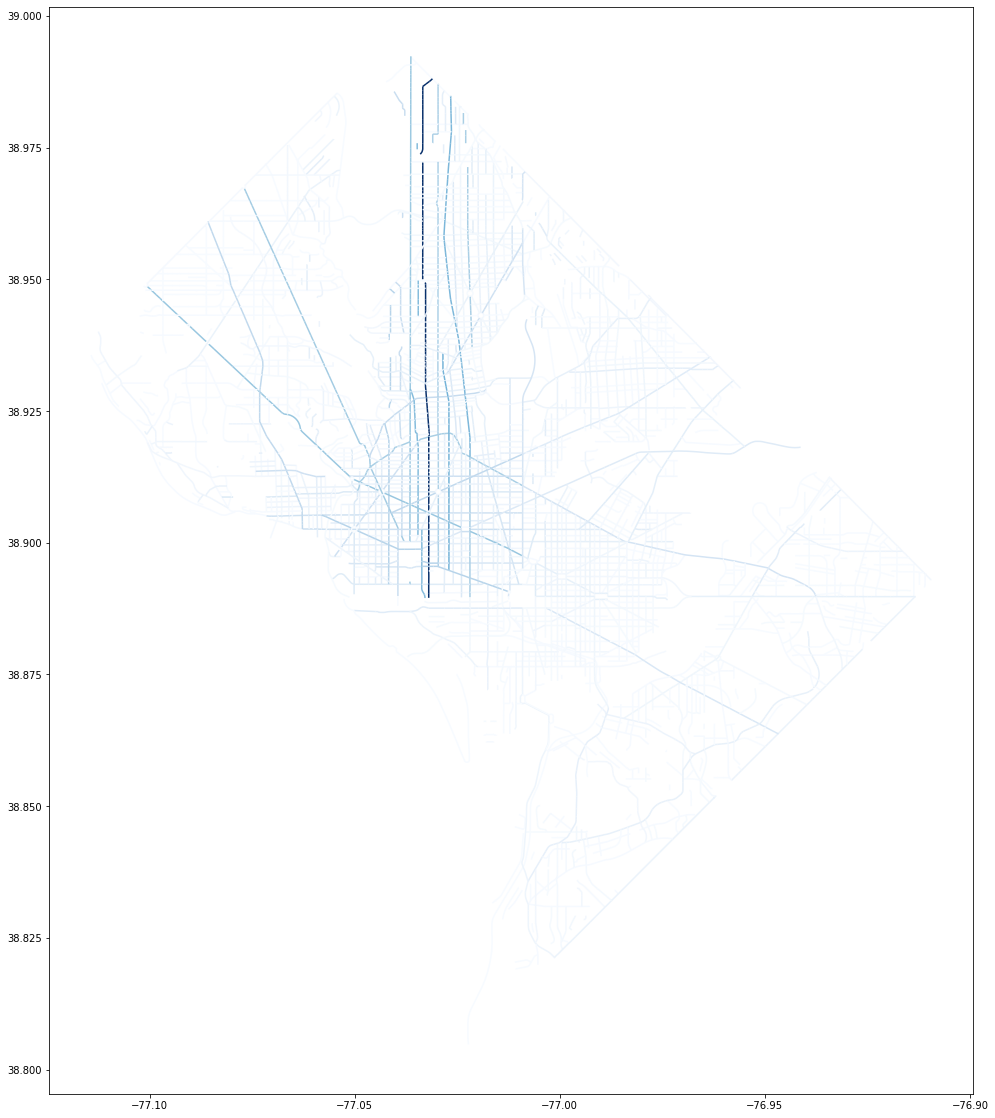

In [11]:
# gradient of accidents plotted to roads
roads_block.plot(figsize=(20,20),
                 legend=False,
                 column='Accidents',
                cmap ='Blues')

Although this is a good starting point, there are a couple of problems.  

First, this is all historical data, and the roadways have changed a lot since 2011.  I do not have the exact dates that each bike lane was installed, so I cannot temporally analyze crash data before and after bike infrastructure was installed on any particular roadway.  

Second, the above visualization only ties crash data to a ROUTEID.  A ROUTEID correlates to the entirety of a roadway.  For example, ROUTEID 11001402 which has the highest number of crashes across the historical data is 14th St NW which is a very long roadway.

I would like to look at the 2022 data to focus on the most recent depiction of the biking situation in DC and I will also tie the accidents to the subsections of the ROUTES.  These subsections are available in the Roadway_Block dataset that is included in the index at the beginning of this notebook. The Roadway_Block data will also allow me to identify which sections of roadway have bike lanes and which do not.

NOTE:  For more information on how roadways are labeled and laid out in DC, see [here](https://www.washingtonian.com/2008/02/22/driving-in-dc-a-crash-course-on-the-grid-system/).

### Looking at Today

To get a better look at the current situatuon, I am going to narrow down my analysis to 2022 data.

As soon as I do this, I find that there are 8 crashes that are labeled as "Route not found," which is a problem for my analysis, so I use the address data that is included in the data file to find the ROUTEID.

In [12]:
# focus on 2022 to get a more recent depiction of the situation
crashes_2022 = pd.read_csv('Crashes_in_DC_bikes.csv')
crashes_2022['Report_Date_Short'] = pd.to_datetime(crashes_2022['REPORTDATE']).dt.date
crashes_2022['Report_Date_Year'] = pd.to_datetime(crashes_2022['REPORTDATE']).dt.year
crashes_2022 = crashes_2022[crashes_2022['Report_Date_Year'] == 2022]

# there are 8 accidents for 2022 that are missing route IDs, so I use find them based on the text description
missing_2022 = crashes_2022[crashes_2022['ROUTEID'] == 'Route not found']
missing_2022 = missing_2022[['OBJECTID', 'ROUTEID', 'ADDRESS']]

# since there are only 8, I use a numpy select to clean up the missing lines
conditions = [
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144022304),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144024872),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144025461),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144027205),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144028059),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144029936),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144030032),
    (crashes_2022['ROUTEID'] == 'Route not found') & (crashes_2022['OBJECTID'] == 144032425)
]

# I took these from the roadways file included in the data sets.  I could have used merges and split functions
# to find these, but with only 8, it was easier to just do it by hand by using the text address.
results = [13079822,
          11001602,
          11001402,
          11033472,
          12039262,
          13061162,
          11001102,
          11063182]

crashes_2022['ROUTEID'] = np.select(conditions, results, crashes_2022['ROUTEID'])

# Now we can redo our most dangerous calculations for 2022 
most_dangerous_2022 = most_dangerous_segs.copy()
most_dangerous_2022.drop('Accidents', axis=1, inplace=True)
most_dangerous_2022 = crashes_2022.groupby(['ROUTEID'])['OBJECTID'].count()
most_dangerous_2022 = most_dangerous_2022.to_frame()
most_dangerous_2022 = most_dangerous_2022.reset_index()
most_dangerous_2022.columns=(['ROUTEID', 'Accidents'])
most_dangerous_2022 = most_dangerous_2022.sort_values(by='Accidents', ascending=False)
most_dangerous_2022

,ROUTEID,Accidents
28,11040042,5
14,11001402,5
87,13081512,5
94,15065322,4
9,11000702,4
...,...,...
38,11064672,1
37,11064612,1
36,11064282,1
35,11064092,1


<AxesSubplot:>

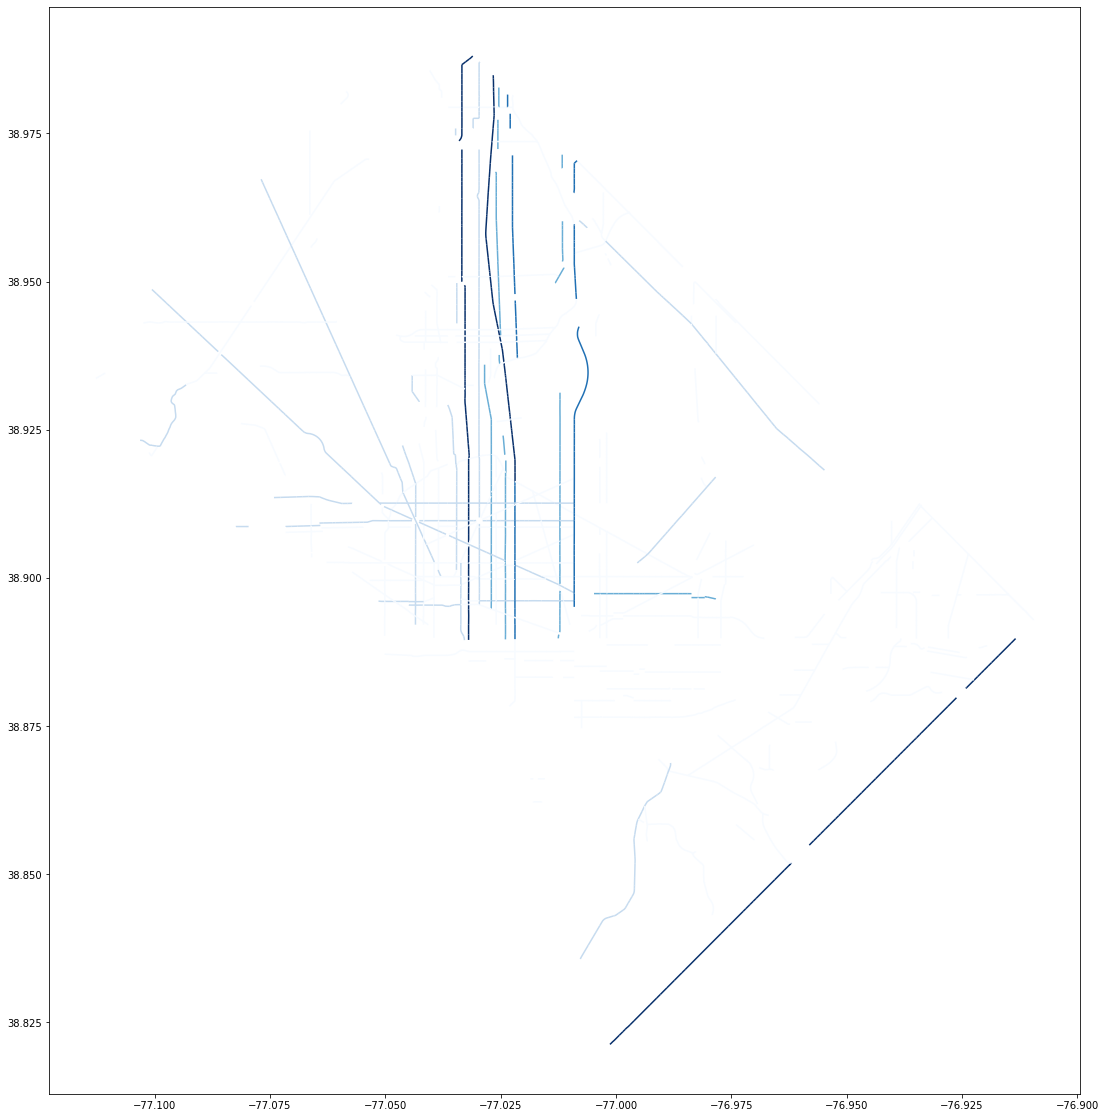

In [13]:
# create a data file of road polygons in DC
shp_path = "Roadway_Block.shp"
roads_block_2022 = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads_block_2022 = roads_block_2022.merge(most_dangerous_2022, on='ROUTEID', how='left')

# gradient of accidents plotted to roads for 2022
roads_block_2022.plot(figsize=(20,20),
                 legend=False,
                 column='Accidents',
                cmap ='Blues')

### Let's Get More Specific

This is a great overview, but as mentioned above, I want to break each route down into its segments to find the specific subsections of the roads that are safe and dangerous.  Otherwise, long roadways such as 14th street have a much higher number of accidents that is not reflective of the relative safety at any one point along that road and shorter roadways are also skewed.  

In addition, the bike infrastructure changes along the length of a route.  For example, the first mile of 14th street may not have a bike lane, but the second mile may have a protected bike lane.

The biggest issue is that the unique key for the subsections of roads is the BLOCKKEY, and this information is not captured in the bike crash data file.

In order to make this connection, I begin by using the MAR_ADDRESS field in the crashes dataframe.  The MAR_ADDRESS is the nearest street address to the lat/long of the crash which is obtained through a web service.  This will give me the street number and name where the bike crash happened.  I then can find which BLOCKKEY's address range contains the street name and number where the accident happened.

In [14]:
# break out the address number where the crash took place to figure out which segment it corresponds to in the roadways data
crashes_2022['Street Address Number'] = crashes_2022['MAR_ADDRESS'].str.split(' ').str[0]

# this presents two instances that are problems 
print('These will be a problem: ',
      crashes_2022[crashes_2022['CCN'] == 22103054]['MAR_ADDRESS'],
      crashes_2022[crashes_2022['CCN'] == 22080580]['MAR_ADDRESS'])

# I use the lat and long data in the file to find an approximate address for these two points
crashes_2022.at[4740,'MAR_ADDRESS'] = '2911'
crashes_2022.at[4726,'MAR_ADDRESS'] = '900'
crashes_2022['Street Address Number'] = crashes_2022['MAR_ADDRESS'].str.split(' ').str[0]

print('Problem Solved: ',
      crashes_2022[crashes_2022['CCN'] == 22103054]['MAR_ADDRESS'],
      crashes_2022[crashes_2022['CCN'] == 22080580]['MAR_ADDRESS'])

These will be a problem:  4740    MASSACHUSETTS AVENUE BRIDGE
Name: MAR_ADDRESS, dtype: object 4726    15TH STREET NW AND I STREET NW
Name: MAR_ADDRESS, dtype: object
Problem Solved:  4740    2911
Name: MAR_ADDRESS, dtype: object 4726    900
Name: MAR_ADDRESS, dtype: object


In the next block, I am going to use the ROUTEID field and the street address number that we produced above to find which subsection of the route on which the bike accident occurred.  In short, I match to the ROUTEID to find the overall roadway and then find the BLOCKKEY where the address falls between the low and high bounds for that subsection.

In [15]:
# finding the block key by using the route ID and the street address number
crash_route_match = crashes_2022[['CRIMEID', 'ROUTEID', 'MAR_ADDRESS', 'Street Address Number',
                                  'LATITUDE', 'LONGITUDE']]

print(crash_route_match['Street Address Number'])

# Import a new copy of the roadway blocks data
roadways = pd.read_csv('Roadway_Block.csv')

# merge the accident data with the roadway data in a one to many fashion
roadways_accidents = crash_route_match.merge(roadways,
                                            on='ROUTEID',
                                            how='left')

# keep only the necessary columns
roadways_accidents = roadways_accidents[['CRIMEID', 'ROUTEID', 'MAR_ADDRESS', 'Street Address Number',
                                         'ROUTENAME', 'ROADTYPE', 'BLOCKKEY', 'TOTALTRAVELLANES',
                                         'TOTALPARKINGLANES','BIKELANE_PARKINGLANE_ADJACENT','BIKELANE_CONTRAFLOW',
                                         'BIKELANE_CONVENTIONAL','BIKELANE_DUAL_PROTECTED','BIKELANE_PROTECTED',
                                         'BIKELANE_BUFFERED','TOTALBIKELANES','BIKELANE_DUAL_BUFFERED',
                                         'SPEEDLIMITS_OB', 'ADDRESS_RANGE_HIGH', 'ADDRESS_RANGE_LOW',
                                         'LATITUDE', 'LONGITUDE']]

# convert the street address number to a float to allow comparrison 
roadways_accidents['Street Address Number'] = roadways_accidents['Street Address Number'].astype(float)

# keep only rows where the street address number of the accident is between the low and high address for the road subsection
roadways_accidents = roadways_accidents[(roadways_accidents['Street Address Number'] <= roadways_accidents['ADDRESS_RANGE_HIGH']) &
                                       (roadways_accidents['Street Address Number'] >= roadways_accidents['ADDRESS_RANGE_LOW'])]


4675    1070
4678     501
4679    3033
4680    2514
4681    1705
        ... 
4805     700
4806     623
4807    1101
4808    2001
4809     990
Name: Street Address Number, Length: 133, dtype: object


Now that I know the specific subsection of the road on which each bike accident happened, I can group them together to count up the accidents on each subsection.

In [16]:
# group by the newly found blockid and count up the accidents
roadways_accidents_copy = roadways_accidents.copy()
roadways_accidents_counts = roadways_accidents_copy.groupby(by=['BLOCKKEY'])['CRIMEID'].count()

# I use the CRIMEID for counting, because it is the unique identifier for each accident
roadways_accidents_counts = roadways_accidents_counts.reset_index()
roadways_accidents_counts.columns=(['BLOCKKEY', 'Accidents'])
roadways_accidents_counts = roadways_accidents_counts.sort_values(by='Accidents', ascending=False)
roadways_accidents_counts

,BLOCKKEY,Accidents
48,692d7ce1433f9a1fcfa149b61c6a621f,2
12,1b244e1ebc8896b83cd4b5fba0402fcc,2
1,0357cf222e40b7897ea43d00199a1f06,2
69,9ddb501ff29460d91e0387a0845ed7fc,2
34,44fe594252a7b23a633ff9872d6b86f7,2
...,...,...
38,52aa2d9fa3891d0689ba766d6f93f69f,1
37,5037bffb1d60de00d879cb088e2d9aca,1
36,4f3fc9369cc0bc6118e9f683b6f4bb33,1
35,469541a0cfc3eacc325b0fe7dbdb6382,1


Having how many accidents happened on each unique block, I can join this data back to the roadways dataframe so that I have all of the different characteristics of the subsections and the accidents in the same place.

I also add a Bikelane_Type column to unify the type of bikelane into one column.  It was originally stored in about 10 different columns for each different type in each direction.  For my purposes, I only care about the type along that segment, so I combined them, below.

In [17]:
# make a copy of the roadway accidents df
roadway_accidents_combined = roadways_accidents.copy()

# join the copy to the accidents counts df we made, above
roadway_accidents_combined = roadway_accidents_combined.merge(roadways_accidents_counts, on='BLOCKKEY')

# apply a single label for bike lane type as opposed to various columns
conditions = [
    # conventional bikelane
    roadway_accidents_combined['BIKELANE_CONVENTIONAL'].isna() == False,
    # dual protected bike lane
    roadway_accidents_combined['BIKELANE_DUAL_PROTECTED'].isna() == False,
    # protected bike lane
    roadway_accidents_combined['BIKELANE_PROTECTED'].isna() == False,
    # buffered bike lane
    roadway_accidents_combined['BIKELANE_BUFFERED'].isna() == False
]

results = ['Conventional','Dual Protected','Protected', 'Buffered']

roadway_accidents_combined['Bikelane_Type'] = np.select(conditions, results, 'None')

# make another df for a correlation chart, later
roadway_accidents_corr = roadway_accidents_combined.copy()

# remove excess columns
roadway_accidents_combined.drop(['BIKELANE_CONVENTIONAL', 'BIKELANE_DUAL_PROTECTED', 'BIKELANE_PROTECTED',
                        'BIKELANE_CONTRAFLOW', 'BIKELANE_PARKINGLANE_ADJACENT', 'BIKELANE_BUFFERED',
                        'BIKELANE_DUAL_BUFFERED', 'ADDRESS_RANGE_HIGH', 'ADDRESS_RANGE_LOW', 'ROADTYPE'],
                        axis=1, 
                        inplace=True)
roadway_accidents_combined

,CRIMEID,ROUTEID,MAR_ADDRESS,Street Address Number,ROUTENAME,BLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALBIKELANES,SPEEDLIMITS_OB,LATITUDE,LONGITUDE,Accidents,Bikelane_Type
0,30750192661,12004402,1070 44TH STREET NE,1070.0,44TH ST NE,f4bc022eaba3eb81003d1120806a078f,2.0,2.0,0.0,25.0,38.904959,-76.938603,1,None
1,31018790177,14031332,501 6TH STREET SW,501.0,E ST SW,d08f74a2bb79d90191e89d4110df2d62,2.0,2.0,0.0,20.0,38.882950,-77.020255,1,None
2,30776874178,11001502,3033 16TH STREET NW,3033.0,15TH ST NW,9c26b6aea5aa0879dc5ccaeebb1a8dac,1.0,2.0,1.0,25.0,38.927564,-77.035723,1,Conventional
3,31304044728,13079822,2514 SHERIDAN ROAD SE,2514.0,SHERIDAN RD SE,337abbaa202564de77ee728a2c146d1e,2.0,1.0,0.0,20.0,38.860709,-76.993648,1,None
4,31204748832,11001702,1705 L STREET NW,1705.0,17TH ST NW,1858f5765f77d505554ea35df09c6a4a,1.0,2.0,2.0,NaN,38.903742,-77.039013,1,Buffered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,37880948633,12061162,4169 MINNESOTA AVENUE NE,4169.0,MINNESOTA AVE NE,af53bd8bdff9ce315f0166a9be8ee17e,4.0,0.0,0.0,25.0,38.899877,-76.944405,1,None
129,37971460584,11050892,700 K STREET NW,700.0,K ST NW,65f231d155abd3b337500104ad173dab,4.0,2.0,0.0,20.0,38.901780,-77.021916,1,None
130,37906591095,11042442,623 H STREET NW,623.0,H ST NW,d27e54246ab6d2b8fac9e6fa07ceb8c8,4.0,2.0,0.0,25.0,38.900024,-77.020928,1,None
131,37811238290,12000302,2001 3RD STREET NE,2001.0,3RD ST NE,c61a0d6cad4283a40608f14f2af850cd,1.0,2.0,1.0,20.0,38.916994,-77.002033,1,Conventional


Now, I want to use a GROUPBY and COUNT to see what the different types of bike lanes or lack thereof look like alongside accidents along those sections.

In [18]:
lane_types_accidents = roadway_accidents_combined.groupby(by='Bikelane_Type')['Accidents'].sum()
lane_types_accidents = lane_types_accidents.to_frame()
lane_types_accidents.sort_values(by='Accidents', ascending=False, inplace=True)
lane_types_accidents = lane_types_accidents.reset_index()
lane_types_accidents['% of Total'] = round((lane_types_accidents['Accidents']/
                                            sum(lane_types_accidents['Accidents'])) * 100, 0)
lane_types_accidents

,Bikelane_Type,Accidents,% of Total
0,None,110,73.0
1,Conventional,28,19.0
2,Buffered,10,7.0
3,Dual Protected,3,2.0


In [19]:
# some quick odds likely calculations
odds_likely = round(110/(28+10+3), 2)
print(odds_likely)

safe_odds_likely = round((110+28+10)/3, 2)
print(safe_odds_likely)

2.68
49.33


### Summing it All Up

Overall, biking in bike lanes is much safer than on roads that do not have any bike infrastructure.  This seems to follow common sense, but it is nice to see the actual numbers that back up my anecdotal experience of biking the roads of DC.

You are 2.7 times more likely to be in a bike accident in 2022 in DC if you are on a road with no bike lane.  You reduce your risk dramatically by biking in protected bike lanes.  This is reflected by the DC government's plan to build 20 more miles of protected bike lanes by [2023](https://ddot.dc.gov/page/bicycle-lanes).  

If I were to continue this project, I would look at other contributing factors such as speed limit along the roadway sections (I do a quick correlation matrix below).  I would also want to find a way to normalize the data against bike traffic data, if possible.

In the ideal world, I would like to get to the point where I could mathematically score any given roadway segment in DC based on the safety of that stretch of road.  With this, I would then like to build an app that could recommend the safest route from any point A to B in DC.  This would become very complicated, very quickly with the balancing act between safety and speed of the route being essential.

In closing, I enjoyed this opportunity to dive into a dataset that is meaningful to me, and I hope it gave you all to learn more about DC!  As mentioned in one of our homework assignments, DC is not a state, and there are a bunch of nuances that come along with that such as our license plates that say "Taxation Without Representation."  If you are curious, you can read more about it, [here](https://statehood.dc.gov/page/why-statehood-dc).


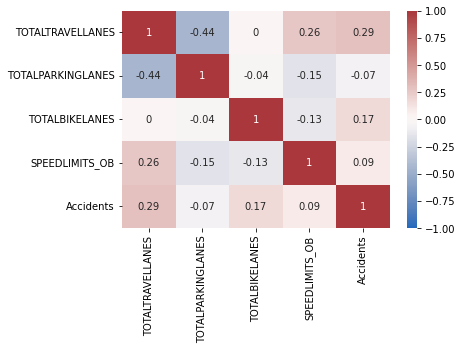

In [20]:
# looking at some other factors that may contribute to accident rates
roadways_accidents_corr = roadway_accidents_corr[['TOTALTRAVELLANES','TOTALPARKINGLANES',
                                                  'BIKELANE_PARKINGLANE_ADJACENT',
                                                  'BIKELANE_CONTRAFLOW', 'BIKELANE_BUFFERED','TOTALBIKELANES',
                                                  'BIKELANE_DUAL_BUFFERED','SPEEDLIMITS_OB',
                                                  'Bikelane_Type', 'Accidents']]
# visualizing the correlation in a matrix
matrix = roadways_accidents_corr.corr().round(2)
sns.heatmap(matrix,
            annot=True,
            vmax=1,
            vmin=-1,
            center=0,
            cmap='vlag')
plt.show()